
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_51166/3046165550.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


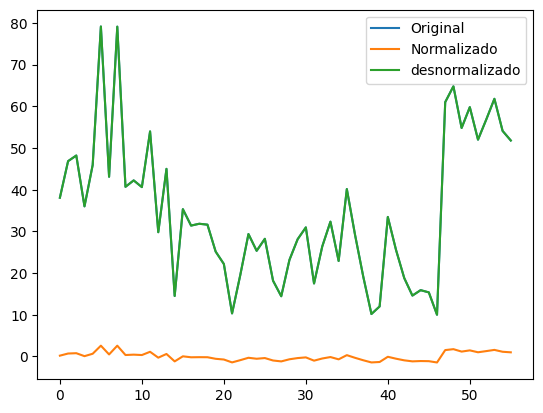

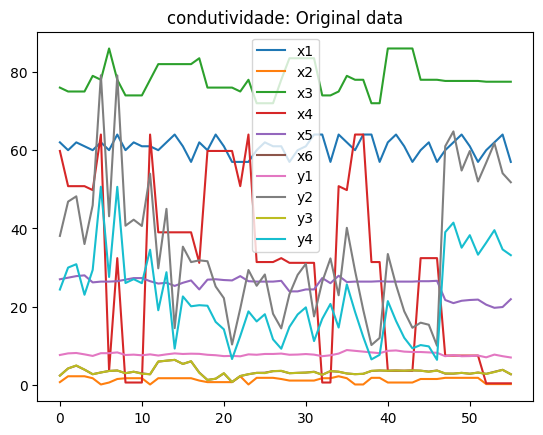

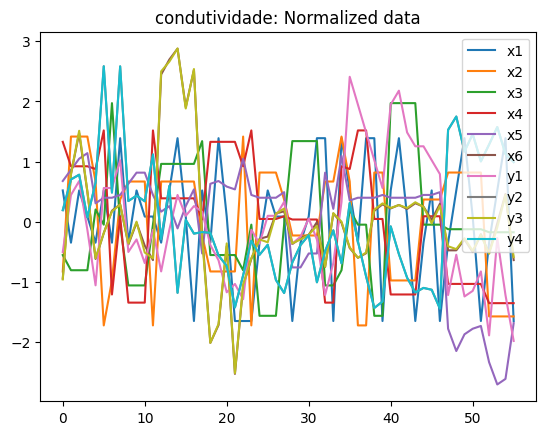

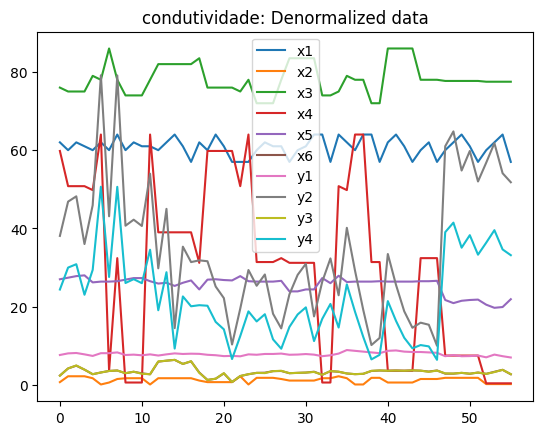

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5, x6  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5'], df['x6']

    input = np.vstack([x1, x2, x3, x4, x5, x6 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y2"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y2")
test_out_scaler()
show_norm(label="condutividade")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-05-26 19:59:54.427284: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 19:59:54.460505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 19:59:54.460541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 19:59:54.461559: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 19:59:54.467136: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 19:59:54.468014: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=6,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[30], [25], [20], [25, 15], [20, 10], [35], [10, 5], [30, 15]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  1.4209345629997188
Stopped at epoch:  22
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.22853776100055256
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.2264507350000713
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.24329690700051287
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.26474445200074115
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.17213538400028483
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 7 ++++++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_5_0,0.822655,0.527486,0.993783,0.845368,52.216579,80.717588,2.454796,43.887995
model_1_5_1,0.845577,0.509969,0.990479,0.837622,45.467552,83.709815,3.759807,46.086304
model_1_5_2,0.863742,0.493692,0.986880,0.830079,40.118946,86.490420,5.181026,48.227154
model_1_5_3,0.878111,0.478727,0.983129,0.822855,35.888307,89.046818,6.662193,50.277584
model_1_5_4,0.889448,0.465062,0.979332,0.816015,32.550425,91.381165,8.161308,52.218907
model_1_5_5,0.898364,0.452644,0.975570,0.809595,29.925126,93.502407,9.647169,54.041097
model_1_5_6,0.905350,0.441394,0.971899,0.803607,27.868190,95.424217,11.096485,55.740527
model_1_5_7,0.910798,0.431226,0.968363,0.798051,26.264040,97.161206,12.492783,57.317291
model_1_5_8,0.915024,0.422048,0.964991,0.792919,25.019991,98.729029,13.824401,58.773885
model_1_5_9,0.918278,0.413775,0.961802,0.788195,24.061782,100.142337,15.083804,60.114793


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Elapsed time:  0.21951170600004843
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Elapsed time:  0.3047094859994104
Stopped at epoch:  6
2/2 [==============================] - 0s 13ms/step


2024-05-26 20:01:04.252473: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Elapsed time:  0.2716961590003848
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Elapsed time:  0.21783464700001787
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Elapsed time:  0.3318004620005013
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Elapsed time:  0.27048131700030353
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Elapsed time:  0.3463838449997638
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Elapsed time:  0.24981941999976698
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_6] | 9 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_6_0,0.933366,0.897903,0.763662,0.863069,19.619256,21.665242,41.925465,31.199469
model_1_6_24,0.937926,0.732921,0.640771,0.736698,18.276660,56.674665,63.725938,59.992904
model_1_6_1,0.938263,0.886450,0.759744,0.855987,18.177533,24.095533,42.620527,32.813177
model_1_6_23,0.938345,0.735157,0.643221,0.738699,18.153439,56.200167,63.291266,59.537153
model_1_6_22,0.938798,0.737627,0.645905,0.740900,18.019868,55.676027,62.815148,59.035611
model_1_6_21,0.939289,0.740353,0.648842,0.743320,17.875515,55.097470,62.294103,58.484117
model_1_6_20,0.939816,0.743360,0.652049,0.745978,17.720157,54.459351,61.725168,57.878555
model_1_6_19,0.940381,0.746674,0.655544,0.748892,17.553738,53.756177,61.105229,57.214551
model_1_6_18,0.940984,0.750322,0.659342,0.752082,17.376468,52.981997,60.431475,56.487646
model_1_6_17,0.941621,0.754333,0.663459,0.755568,17.188919,52.130992,59.701047,55.693370


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Elapsed time:  4.628307506000056
Stopped at epoch:  109
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Elapsed time:  0.5316098859993872
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Elapsed time:  0.23121459400044841
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Elapsed time:  0.5079919730005713
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Elapsed time:  0.05097273100000166
Stopped at epoch:  0
1/1 [==============================] - 0s 27ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Elapsed time:  0.04815432899977168
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Elapsed time:  0.03977405

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_7_1,0.969469,0.821284,0.934147,0.934692,8.989353,28.301910,31.085767,29.611978
model_1_7_2,0.969469,0.821284,0.934147,0.934692,8.989353,28.301910,31.085767,29.611978
model_1_7_12,0.969469,0.821284,0.934146,0.934692,8.989347,28.301930,31.085775,29.611972
model_1_7_22,0.969469,0.821284,0.934146,0.934692,8.989347,28.301930,31.085775,29.611972
model_1_7_21,0.969469,0.821284,0.934146,0.934692,8.989347,28.301930,31.085775,29.611972
model_1_7_20,0.969469,0.821284,0.934146,0.934692,8.989347,28.301930,31.085775,29.611972
model_1_7_19,0.969469,0.821284,0.934146,0.934692,8.989347,28.301930,31.085775,29.611972
model_1_7_18,0.969469,0.821284,0.934146,0.934692,8.989347,28.301930,31.085775,29.611972
model_1_7_17,0.969469,0.821284,0.934146,0.934692,8.989347,28.301930,31.085775,29.611972
model_1_7_16,0.969469,0.821284,0.934146,0.934692,8.989347,28.301930,31.085775,29.611972


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Elapsed time:  0.42346849699970335
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Elapsed time:  0.3651023170004919
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Elapsed time:  0.35449863499979983
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Elapsed time:  0.33553657599986764
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Elapsed time:  0.3502361819992075
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Elapsed time:  0.3086206710004262
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Elapsed time:  0.363687807

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_8_0,0.969469,0.931785,0.999962,0.988532,8.989347,3.596332,0.008758,1.908051
model_1_8_1,0.969609,0.932088,0.999961,0.988582,8.948227,3.580364,0.008953,1.899699
model_1_8_2,0.975092,0.936176,0.999554,0.989003,7.333905,3.364848,0.102624,1.829685
model_1_8_3,0.979395,0.937716,0.998486,0.988568,6.066733,3.283621,0.347910,1.902112
model_1_8_4,0.982760,0.937396,0.996959,0.987521,5.076080,3.300523,0.699107,2.076327
model_1_8_5,0.985377,0.935742,0.995122,0.986049,4.305513,3.387719,1.121265,2.321159
model_1_8_6,0.987400,0.933158,0.993093,0.984296,3.709879,3.523963,1.587710,2.612788
model_1_8_7,0.988952,0.929951,0.990959,0.982372,3.253025,3.692986,2.078124,2.933050
model_1_8_8,0.990130,0.926358,0.988788,0.980357,2.906018,3.882451,2.577273,3.268238
model_1_8_9,0.991014,0.922554,0.986628,0.978315,2.645671,4.082975,3.073703,3.608015


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Elapsed time:  0.38894664100007503
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Elapsed time:  0.2952801769997677
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Elapsed time:  0.31543718600005377
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Elapsed time:  0.3533455150000009
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Elapsed time:  0.29371923500002595
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Elapsed time:  0.32715198500045517
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Elapsed time:  0.35831730

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_9_24,0.990322,0.913172,0.996284,0.974220,2.849425,16.075923,1.796454,9.356177
model_1_9_23,0.990438,0.914268,0.996336,0.974549,2.815357,15.872977,1.771265,9.236875
model_1_9_22,0.990565,0.915479,0.996393,0.974912,2.778048,15.648824,1.743690,9.105236
model_1_9_21,0.990703,0.916814,0.996455,0.975311,2.737297,15.401613,1.713632,8.960208
model_1_9_20,0.990854,0.918286,0.996523,0.975751,2.692861,15.129076,1.680888,8.800519
model_1_9_19,0.991018,0.919906,0.996596,0.976235,2.644562,14.829022,1.645412,8.624972
model_1_9_18,0.991196,0.921689,0.996676,0.976766,2.592200,14.499033,1.606970,8.432182
model_1_9_17,0.991388,0.923647,0.996762,0.977349,2.535634,14.136522,1.565580,8.220783
model_1_9_16,0.991595,0.925794,0.996853,0.977986,2.474787,13.738959,1.521134,7.989394
model_1_9_15,0.991816,0.928145,0.996952,0.978683,2.409652,13.303661,1.473706,7.736627


DataFrame salvo em ../results/metrics_1_9
Testando combinação 2: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Elapsed time:  0.632730234000519
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Elapsed time:  0.3846357980000903
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Elapsed time:  0.3004663800002163
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Elapsed time:  0.3422493449998001
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Elapsed time:  0.3455943480003043
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Elapsed time:  0.3476897789996656
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/

2024-05-26 20:03:41.020411: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.35536228500041034
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [2_5] | 21 ++++++++++++++++++
Elapsed time:  0.2919652310001766
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_5] | 22 ++++++++++++++++++
Elapsed time:  0.3490224999995917
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_5] | 23 ++++++++++++++++++
Elapsed time:  0.4038759550003306
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_5] | 24 ++++++++++++++++++
Elapsed time:  0.307391307999751
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_5] | 25 ++++++++++++++++++
Elapsed time:  0.31080378200022096
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_6] | 1 ++++++++++++++++++
Elapsed time:  0.3677649690007456
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step

2024-05-26 20:03:56.739439: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.31595343699973455
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_6] | 19 ++++++++++++++++++
Elapsed time:  0.3851368689993251
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_6] | 20 ++++++++++++++++++
Elapsed time:  0.31047742499958986
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_6] | 21 ++++++++++++++++++
Elapsed time:  0.36861170399970433
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_6] | 22 ++++++++++++++++++
Elapsed time:  0.348463047000223
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [2_6] | 23 ++++++++++++++++++
Elapsed time:  0.35661067600085516
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [2_6] | 24 ++++++++++++++++++
Elapsed time:  0.24704979699981777
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_6_0,0.817168,0.527687,0.884630,0.750778,53.832022,81.263827,35.528506,59.741330
model_2_6_1,0.838699,0.512671,0.884309,0.744878,47.492510,83.847305,35.627544,61.155655
model_2_6_2,0.855191,0.491005,0.883699,0.736277,42.636616,87.575073,35.815131,63.217443
model_2_6_3,0.867718,0.465065,0.882891,0.725931,38.948391,92.038215,36.064196,65.697491
model_2_6_4,0.877136,0.436686,0.881953,0.714580,36.175402,96.920995,36.352880,68.418356
model_2_6_5,0.884128,0.407254,0.880943,0.702786,34.116580,101.984815,36.663906,71.245572
model_2_6_6,0.889237,0.377789,0.879902,0.690960,32.612424,107.054398,36.984543,74.080352
model_2_6_7,0.892890,0.349019,0.878859,0.679397,31.536774,112.004545,37.305891,76.852236
model_2_6_21,0.895059,0.107283,0.868599,0.581337,30.898319,153.596382,40.465472,100.358304
model_2_6_8,0.895425,0.321437,0.877834,0.668297,30.790326,116.750175,37.621546,79.513163


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Elapsed time:  0.363211035999484
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Elapsed time:  0.3473785329997554
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Elapsed time:  0.33393866599999456
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Elapsed time:  0.38212491299964313
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Elapsed time:  0.33352627600015694
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Elapsed time:  0.3629226880002534
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Elapsed time:  0.3167010820

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_7_0,0.908468,0.775663,0.933296,0.861413,26.950151,45.618862,7.654272,27.753180
model_2_7_1,0.918736,0.771132,0.910881,0.852933,23.926945,46.540121,10.226338,29.451288
model_2_7_2,0.926536,0.766538,0.885527,0.843627,21.630449,47.474356,13.135753,31.315007
model_2_7_3,0.932404,0.762007,0.858740,0.833968,19.902648,48.395702,16.209487,33.249240
model_2_7_4,0.936767,0.757625,0.831620,0.824299,18.618104,49.286812,19.321503,35.185498
model_2_7_5,0.939960,0.753442,0.804942,0.814857,17.677702,50.137411,22.382818,37.076425
model_2_7_6,0.942251,0.749490,0.779233,0.805800,17.003292,50.941003,25.332932,38.890149
model_2_7_24,0.942497,0.713664,0.545119,0.723411,16.930795,58.226196,52.197330,55.389082
model_2_7_23,0.942769,0.714462,0.550075,0.725177,16.850772,58.063953,51.628688,55.035595
model_2_7_22,0.943059,0.715344,0.555576,0.727134,16.765466,57.884606,50.997426,54.643581


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++


2024-05-26 20:04:18.888042: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.5959844899998643
Stopped at epoch:  10
1/1 [==============================] - 0s 28ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Elapsed time:  0.37942536199989263
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Elapsed time:  0.32329262799976277
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Elapsed time:  0.32484123300037027
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Elapsed time:  0.36481963700043707
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Elapsed time:  0.33294257700072194
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Elapsed time:  0.34281925999948726
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/ste

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_8_0,0.962413,0.946589,0.832533,0.883880,11.066799,10.477128,46.129806,27.254851
model_2_8_1,0.964340,0.942717,0.836598,0.884412,10.499559,11.236491,45.010098,27.129960
model_2_8_2,0.965867,0.938956,0.840129,0.884698,10.050065,11.974373,44.037426,27.062867
model_2_8_3,0.967072,0.935344,0.843200,0.884796,9.695238,12.682858,43.191609,27.039914
model_2_8_4,0.968019,0.931909,0.845873,0.884753,9.416347,13.356574,42.455179,27.050030
model_2_8_5,0.968760,0.928669,0.848204,0.884606,9.198275,13.992311,41.813088,27.084437
model_2_8_6,0.969335,0.925630,0.850239,0.884386,9.028791,14.588287,41.252644,27.136221
model_2_8_7,0.969779,0.922797,0.852018,0.884115,8.898015,15.144040,40.762673,27.199865
model_2_8_8,0.970119,0.920167,0.853575,0.883811,8.798031,15.659989,40.333759,27.271183
model_2_8_9,0.970376,0.917734,0.854940,0.883489,8.722427,16.137164,39.957628,27.346792


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Elapsed time:  0.346409617000063
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Elapsed time:  0.3149450330001855
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Elapsed time:  0.32896138500018424
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Elapsed time:  0.2821295180001471
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Elapsed time:  0.31550548799987155
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Elapsed time:  0.2998240030001398
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Elapsed time:  0.38192075899

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_9_24,0.968909,0.884489,0.813018,0.860459,9.154131,30.513151,29.507522,30.039919
model_2_9_23,0.969258,0.885345,0.816317,0.862153,9.051595,30.287102,28.986809,29.675207
model_2_9_22,0.969638,0.886292,0.819948,0.864021,8.939633,30.036943,28.413841,29.273135
model_2_9_21,0.970052,0.887339,0.823937,0.866078,8.817692,29.760246,27.784317,28.830385
model_2_9_20,0.970502,0.888497,0.828316,0.868340,8.685226,29.454390,27.093386,28.343334
model_2_9_19,0.970989,0.889776,0.833112,0.870826,8.541793,29.116578,26.336396,27.808268
model_2_9_18,0.971515,0.891188,0.838359,0.873553,8.387026,28.743687,25.508434,27.221201
model_2_9_17,0.972079,0.892745,0.844086,0.876540,8.220767,28.332346,24.604691,26.578159
model_2_9_16,0.972683,0.894460,0.850323,0.879806,8.043063,27.879167,23.620430,25.875046
model_2_9_15,0.973324,0.896349,0.857097,0.883369,7.854311,27.380353,22.551472,25.107958


DataFrame salvo em ../results/metrics_2_9
Testando combinação 3: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++
Elapsed time:  0.676830751000125
Stopped at epoch:  8
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Elapsed time:  0.5031149289998211
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Elapsed time:  0.3342237870001554
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Elapsed time:  0.37037849799980904
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Elapsed time:  0.3679705209997337
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Elapsed time:  0.3710576109997419
Stopped at epoch:  6
1/1 [==============================] - 0s 21m

2024-05-26 20:05:12.541271: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3691106360001868
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_1] | 8 ++++++++++++++++++
Elapsed time:  0.3497594509999544
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_1] | 9 ++++++++++++++++++
Elapsed time:  0.37639862400010315
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_1] | 10 ++++++++++++++++++
Elapsed time:  0.306894573000136
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_1] | 11 ++++++++++++++++++
Elapsed time:  0.33740966400000616
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [3_1] | 12 ++++++++++++++++++
Elapsed time:  0.2864151880003192
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [3_1] | 13 ++++++++++++++++++
Elapsed time:  0.3580930789994454
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_0,0.805577,0.823769,0.514233,0.807177,57.244737,80.878485,50.024745,66.359096
model_3_3_1,0.820963,0.803405,0.445261,0.783088,52.714688,90.224221,57.127563,74.649328
model_3_3_22,0.827786,0.625457,-0.544084,0.518141,50.705708,171.890418,159.011261,165.829653
model_3_3_21,0.829068,0.627714,-0.523940,0.522571,50.328352,170.854560,156.936796,164.305037
model_3_3_20,0.830442,0.630226,-0.501861,0.527454,49.923795,169.701944,154.663045,162.624824
model_3_3_19,0.831908,0.633022,-0.477689,0.532832,49.492159,168.418524,152.173879,160.773964
model_3_3_2,0.831908,0.783937,0.374889,0.759434,49.492090,99.158617,64.374531,82.789667
model_3_3_18,0.833463,0.636140,-0.451258,0.538755,49.034083,166.987568,149.451988,158.735536
model_3_3_17,0.835103,0.639620,-0.422399,0.545276,48.551224,165.390543,146.479997,156.491466
model_3_3_16,0.836819,0.643509,-0.390931,0.552453,48.046230,163.605683,143.239366,154.021491


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.3742159419998643
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.34372890700069547
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.3421976839999843
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.3209618440005215
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.3655541549996997
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.3718952220006031
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.34936813900

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_24,0.826801,-0.021537,0.598145,0.377450,50.995672,192.379743,139.547834,167.517656
model_3_4_23,0.828722,-0.008761,0.602424,0.384782,50.430058,189.973684,138.061942,165.544618
model_3_4_22,0.830823,0.005327,0.607125,0.392857,49.811607,187.320586,136.429264,163.371746
model_3_4_21,0.833114,0.020842,0.612284,0.401739,49.136956,184.398709,134.637991,160.981914
model_3_4_20,0.835607,0.037907,0.617935,0.411494,48.402858,181.184973,132.675438,158.356934
model_3_4_19,0.838312,0.056647,0.624117,0.422192,47.606538,177.655879,130.528894,155.478440
model_3_4_18,0.841236,0.077190,0.630866,0.433902,46.745651,173.787114,128.185053,152.327296
model_3_4_17,0.844383,0.099662,0.638221,0.446695,45.818869,169.555170,125.631191,148.885037
model_3_4_16,0.847756,0.124187,0.646217,0.460638,44.825872,164.936493,122.854390,145.133184
model_3_4_15,0.851348,0.150878,0.654888,0.475794,43.768121,159.909878,119.843325,141.055025


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.49727477300075407
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.3413628999996945
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.42453224399923783
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.3264758420000362
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.2886357749994204
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.35679214100036916
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.321242063

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_19,0.801561,0.612042,0.589733,0.616205,58.427282,150.485588,236.782008,191.095733
model_3_5_18,0.805985,0.614640,0.604747,0.625466,57.124659,149.477819,228.116563,186.484347
model_3_5_17,0.810709,0.617404,0.620984,0.635463,55.733623,148.405668,218.745929,181.507012
model_3_5_16,0.815723,0.620327,0.638469,0.646206,54.257607,147.271820,208.654399,176.157757
model_3_5_15,0.821000,0.623397,0.657206,0.657693,52.703661,146.081306,197.840338,170.438474
model_3_5_14,0.826505,0.626593,0.677172,0.669901,51.082889,144.841301,186.317561,164.359535
model_3_5_13,0.832180,0.629891,0.698300,0.682787,49.412007,143.562113,174.123491,157.943940
model_3_5_12,0.837946,0.633256,0.720481,0.696273,47.714289,142.256937,161.321965,151.228748
model_3_5_0,0.842470,0.660662,0.961794,0.839206,46.382217,131.626277,22.050289,80.061103
model_3_5_11,0.843695,0.636643,0.743542,0.710249,46.021443,140.943009,148.012758,144.269965


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.3561237499998242
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.4060385820002921
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.32001391100038745
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.331179456999962
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.4732920930000546
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.39744321600028343
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.36235886400

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_9,0.802962,0.877929,-0.222977,0.548531,58.014764,53.997608,292.402839,166.188309
model_3_6_8,0.816250,0.891341,-0.084621,0.599353,54.102370,48.064929,259.323301,147.480651
model_3_6_0,0.819514,0.994435,0.902915,0.966785,53.141331,2.461449,23.212173,12.226493
model_3_6_7,0.829260,0.905862,0.061024,0.653108,50.271693,41.641548,224.500789,127.692939
model_3_6_1,0.840701,0.987290,0.827258,0.939115,46.902986,5.622049,41.301119,22.412188
model_3_6_6,0.841096,0.921146,0.209656,0.708262,46.786687,34.880803,188.964232,107.390633
model_3_6_5,0.850576,0.936666,0.355443,0.762696,43.995517,28.015479,154.107705,87.353023
model_3_6_2,0.852369,0.977602,0.727691,0.902518,43.467718,9.907810,65.106725,35.883751
model_3_6_4,0.856369,0.951733,0.492327,0.814121,42.289913,21.350712,121.379965,68.423273
model_3_6_3,0.857269,0.965600,0.616421,0.860873,42.024922,15.216439,91.710423,51.213603


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.3343150239998067
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.39526100700004463
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.2742064699996263
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.275288541000009
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.2534430189998602
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.3644019109997316
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.332200101999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_0,0.831195,0.972644,0.988437,0.980410,49.701970,12.823356,5.405039,9.332380
model_3_7_1,0.861286,0.971792,0.988514,0.980002,40.842198,13.222817,5.369175,9.526998
model_3_7_2,0.885156,0.969478,0.988313,0.978704,33.814030,14.307248,5.463007,10.145243
model_3_7_3,0.903991,0.965952,0.987873,0.976664,28.268256,15.960072,5.668507,11.116977
model_3_7_4,0.918756,0.961463,0.987220,0.974024,23.921037,18.064515,5.973994,12.374865
model_3_7_5,0.930238,0.956249,0.986373,0.970917,20.540339,20.508398,6.369504,13.854797
model_3_7_6,0.939082,0.950532,0.985357,0.967470,17.936370,23.188227,6.844544,15.497083
model_3_7_7,0.945814,0.944510,0.984196,0.963796,15.954116,26.011237,7.387414,17.247095
model_3_7_8,0.950865,0.938353,0.982916,0.959998,14.467010,28.897543,7.985468,19.056568
model_3_7_9,0.954584,0.932200,0.981547,0.956160,13.372161,31.781473,8.625661,20.884622


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.29175987799953873
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.36301338800058147
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.3724670769997829
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.34807566400013457
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.3341857559998971
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.3026938960001644
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.292570024

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_24,0.943485,0.779137,0.829450,0.812203,16.640000,42.452938,68.369419,54.648940
model_3_8_23,0.944103,0.780581,0.832054,0.814395,16.458080,42.175500,67.325754,54.010923
model_3_8_22,0.944780,0.782184,0.834926,0.816818,16.258606,41.867358,66.174459,53.305987
model_3_8_21,0.945522,0.783965,0.838091,0.819492,16.040264,41.525052,64.905691,52.527706
model_3_8_20,0.946332,0.785943,0.841575,0.822443,15.801730,41.144856,63.508727,51.669043
model_3_8_19,0.947215,0.788140,0.845407,0.825696,15.541727,40.722545,61.972542,50.722544
model_3_8_18,0.948175,0.790581,0.849615,0.829277,15.259097,40.253400,60.285790,49.680415
model_3_8_17,0.949215,0.793292,0.854228,0.833215,14.952813,39.732242,58.436631,48.534319
model_3_8_16,0.950338,0.796304,0.859276,0.837541,14.622069,39.153281,56.412986,47.275488
model_3_8_15,0.951546,0.799650,0.864788,0.842285,14.266498,38.510027,54.203272,45.895091


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.6965539200000421
Stopped at epoch:  15
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.30245162099981826
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.29427436200057855
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.3848612880001383
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.3242645390000689
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.2904304929998034
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.362938328

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_24,0.976198,0.867890,0.841200,0.858969,7.008250,18.513130,28.167253,23.056245
model_3_9_23,0.976281,0.868758,0.841480,0.859506,6.983719,18.391484,28.117552,22.968465
model_3_9_22,0.976372,0.869718,0.841787,0.860099,6.956933,18.256862,28.063150,22.871589
model_3_9_21,0.976471,0.870782,0.842123,0.860753,6.927679,18.107841,28.003462,22.764604
model_3_9_20,0.976579,0.871958,0.842492,0.861475,6.895843,17.943029,27.938097,22.646593
model_3_9_19,0.976697,0.873258,0.842894,0.862270,6.861306,17.760906,27.866737,22.516583
model_3_9_18,0.976824,0.874694,0.843332,0.863145,6.823932,17.559637,27.789063,22.373480
model_3_9_17,0.976960,0.876279,0.843808,0.864108,6.783657,17.337448,27.704564,22.216089
model_3_9_16,0.977107,0.878029,0.844325,0.865166,6.740432,17.092299,27.612956,22.043201
model_3_9_15,0.977264,0.879957,0.844882,0.866325,6.694313,16.822096,27.514092,21.853627


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.6489890560005733
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.3663024620000215
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.2676645430001372
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.33597768300023745
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.2835129400000369
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.34161394700004166
Stopped at epoch:  6
1/1 [==============================] - 0s 16

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_0,0.914342,0.856430,0.851938,0.864835,25.220523,30.594203,47.732496,38.659281
model_4_6_1,0.921071,0.845419,0.847439,0.858105,23.239365,32.940569,49.182919,40.584029
model_4_6_2,0.926235,0.835069,0.843054,0.851697,21.719070,35.146062,50.596588,42.416889
model_4_6_3,0.930165,0.825343,0.838907,0.845661,20.561854,37.218589,51.933509,44.143263
model_4_6_4,0.933124,0.816213,0.835057,0.840017,19.690516,39.164250,53.174655,45.757378
model_4_6_5,0.935320,0.807658,0.831521,0.834768,19.043979,40.987280,54.314545,47.258938
model_4_6_6,0.936917,0.799660,0.828295,0.829902,18.573693,42.691632,55.354399,48.650570
model_4_6_24,0.937075,0.727115,0.802499,0.787604,18.527187,58.150689,63.670632,60.748322
model_4_6_23,0.937282,0.728757,0.803034,0.788536,18.466399,57.800700,63.498151,60.481846
model_4_6_22,0.937501,0.730571,0.803626,0.789565,18.401837,57.414120,63.307339,60.187395


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.3642034069998772
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.38204475499969703
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.2915667859997484
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.3517296999998507
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.3723536369998328
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.34971985099946323
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.2834410220

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.957740,0.981035,0.995753,0.988523,12.442671,4.164666,1.086330,2.716030
model_4_7_1,0.964989,0.981216,0.994095,0.987768,10.308460,4.124982,1.510639,2.894699
model_4_7_2,0.970703,0.980525,0.992163,0.986446,8.626116,4.276708,2.004744,3.207547
model_4_7_3,0.975181,0.979184,0.990049,0.984711,7.307431,4.571102,2.545599,3.617931
model_4_7_4,0.978668,0.977371,0.987827,0.982690,6.280765,4.969147,3.114112,4.096186
model_4_7_5,0.981361,0.975229,0.985556,0.980483,5.488023,5.439633,3.694864,4.618568
model_4_7_6,0.983419,0.972870,0.983286,0.978169,4.882094,5.957632,4.275614,5.166098
model_4_7_7,0.984972,0.970385,0.981053,0.975812,4.424851,6.503426,4.846970,5.723910
model_4_7_8,0.986124,0.967843,0.978883,0.973460,4.085437,7.061471,5.401959,6.280521
model_4_7_9,0.986962,0.965301,0.976798,0.971150,3.838967,7.619694,5.935475,6.827124


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.35965596999994887
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.3236364800004594
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.4092497909996382
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.35515207900061796
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.3646186630003285
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.38201787099933426
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.359758144

2024-05-26 20:10:05.451482: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 33ms/step
+++++++++++ [4_8] | 20 ++++++++++++++++++
Elapsed time:  0.3359504319996631
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_8] | 21 ++++++++++++++++++
Elapsed time:  0.30300306400022237
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_8] | 22 ++++++++++++++++++
Elapsed time:  0.38885139700050786
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [4_8] | 23 ++++++++++++++++++
Elapsed time:  0.3498374659993715
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_8] | 24 ++++++++++++++++++
Elapsed time:  0.34712635899995803
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_8] | 25 ++++++++++++++++++
Elapsed time:  0.32206806399972265
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_0,0.989418,0.996598,0.994343,0.995331,3.115818,0.698859,1.946687,1.286068
model_4_8_1,0.991068,0.996440,0.993774,0.994934,2.629753,0.731489,2.142575,1.395534
model_4_8_2,0.992308,0.996081,0.992890,0.994273,2.264781,0.805106,2.446591,1.577565
model_4_8_3,0.993223,0.995582,0.991788,0.993428,1.995381,0.907801,2.825927,1.810450
model_4_8_24,0.993758,0.985620,0.972625,0.978228,1.837858,2.954417,9.420652,5.997361
model_4_8_23,0.993830,0.985823,0.973003,0.978530,1.816625,2.912791,9.290556,5.914098
model_4_8_4,0.993884,0.994987,0.990545,0.992462,1.800870,1.029962,3.253792,2.076474
model_4_8_22,0.993908,0.986046,0.973419,0.978863,1.793766,2.866944,9.147199,5.822356
model_4_8_21,0.993991,0.986291,0.973878,0.979230,1.769285,2.816525,8.989390,5.721407
model_4_8_20,0.994079,0.986561,0.974382,0.979633,1.743213,2.761102,8.815949,5.610449


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  4.2982931549995556
Stopped at epoch:  89
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.36630458699983137
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.2718643640000664
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.3134525460000077
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.3133581760002926
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.3335108780001974
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.3461185850

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_24,0.994273,0.982792,0.986686,0.983935,1.686245,7.960968,2.847635,5.554689
model_4_9_22,0.994273,0.982792,0.986686,0.983935,1.686245,7.960968,2.847635,5.554689
model_4_9_21,0.994273,0.982792,0.986686,0.983935,1.686245,7.960968,2.847635,5.554689
model_4_9_20,0.994273,0.982792,0.986686,0.983935,1.686245,7.960968,2.847635,5.554689
model_4_9_19,0.994273,0.982792,0.986686,0.983935,1.686245,7.960968,2.847635,5.554689
model_4_9_18,0.994273,0.982792,0.986686,0.983935,1.686245,7.960968,2.847635,5.554689
model_4_9_17,0.994273,0.982792,0.986686,0.983935,1.686245,7.960968,2.847635,5.554689
model_4_9_16,0.994273,0.982792,0.986686,0.983935,1.686245,7.960968,2.847635,5.554689
model_4_9_15,0.994273,0.982792,0.986686,0.983935,1.686245,7.960968,2.847635,5.554689
model_4_9_14,0.994273,0.982792,0.986686,0.983935,1.686245,7.960968,2.847635,5.554689


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++


AttributeError: 'TfMethodTarget' object has no attribute 'model'